# GABOR STIM 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from stimuli import GaborSequenceGenerator
# plt.style.use('dark_background')

In [2]:
GaborSequenceGenerator??

Init signature: GaborSequenceGenerator(batch_size, num_trials, mode='reg', NUM_FRAMES=5, NUM_GABORS=30, WIDTH=128, HEIGHT=128, sigma_base=50, kappa=50, lam=1, gamma=0.2, seed=1000, device='cpu')
Docstring:      <no docstring>
Source:        
class GaborSequenceGenerator(object):
    def __init__(self, batch_size, num_trials, mode='reg',
                 NUM_FRAMES=5, NUM_GABORS=30, WIDTH=128, HEIGHT=128,
                 sigma_base = 50, kappa = 50, lam = 1, gamma=0.2,
                 seed=1000, device='cpu'):
        
        self.batch_size     = batch_size
        self.num_trials     = num_trials
        self.__next_trial__ = 0
        self.mode           = mode
        
        self.sigma_base     = sigma_base
        self.kappa          = kappa
        self.lam            = lam
        self.gamma          = gamma
        self.NUM_FRAMES     = NUM_FRAMES
        self.NUM_GABORS     = NUM_GABORS
        self.WIDTH          = WIDTH
        self.HEIGHT         = HEIGHT
        
     

In [3]:
gabor_dl = GaborSequenceGenerator(batch_size=8, num_trials=10, kappa=20, NUM_FRAMES=5, WIDTH=128, HEIGHT=128)

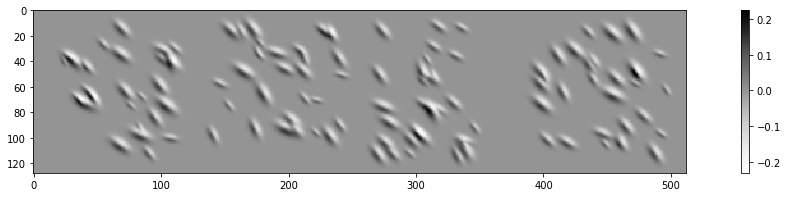

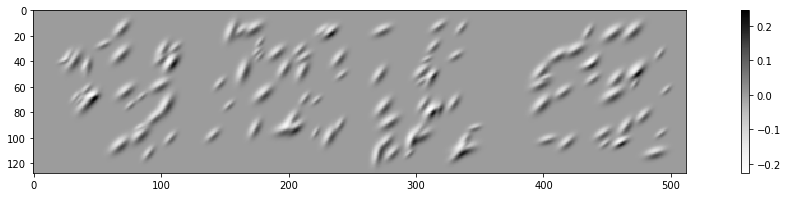

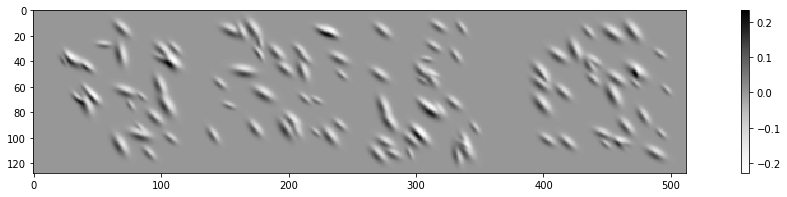

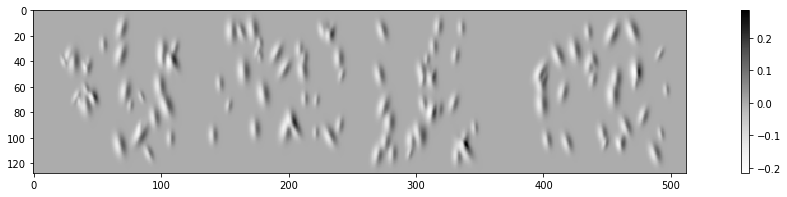

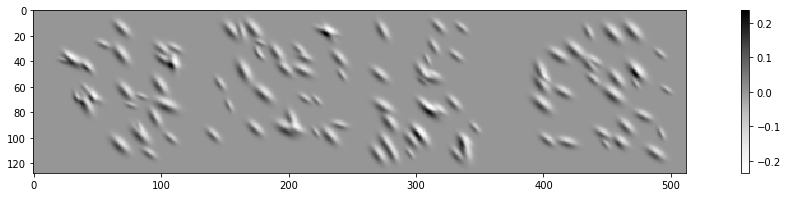

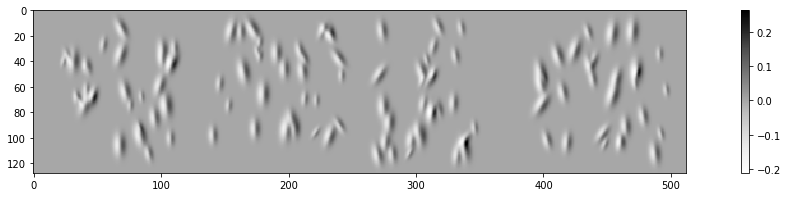

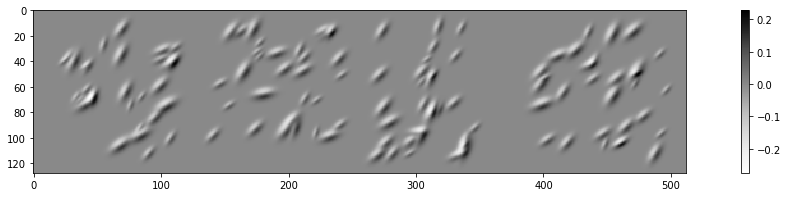

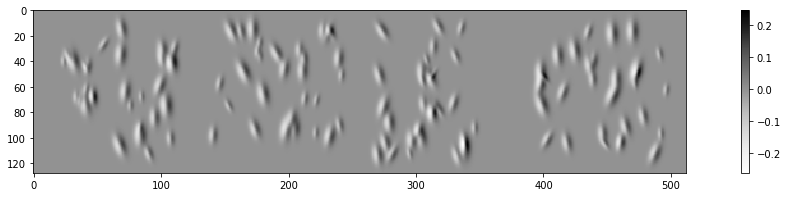

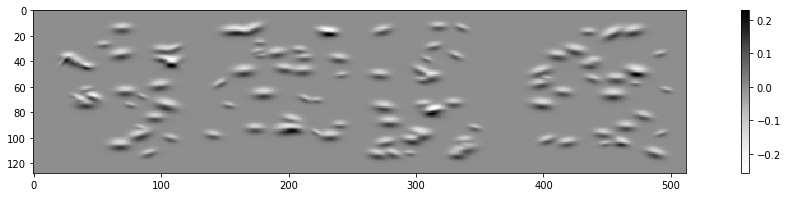

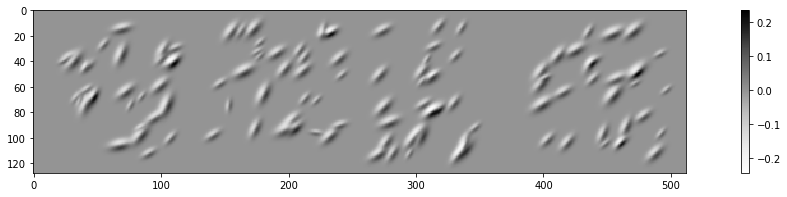

In [5]:
i = 0
for G in gabor_dl:    
    plt.figure(figsize=(20, 3))
    plt.imshow(np.concatenate(G.numpy()[0, :, 0, 0]).T, cmap=plt.cm.Greys);
    plt.colorbar()
    i += 1
    if i == 12:
        break

In [7]:
gabor_dl.mode = 'surp'

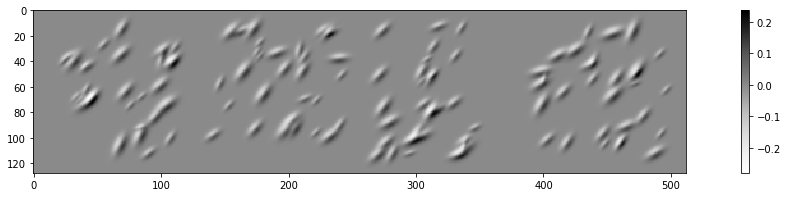

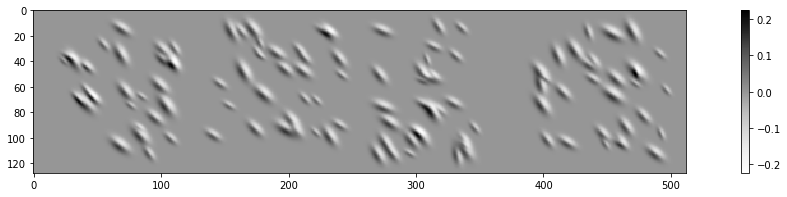

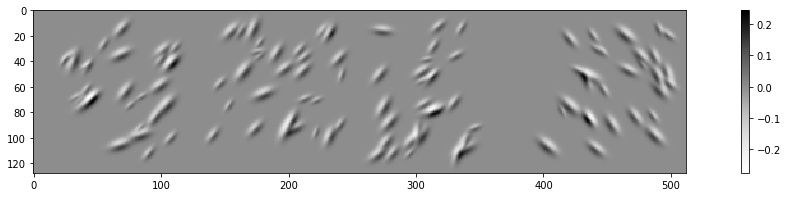

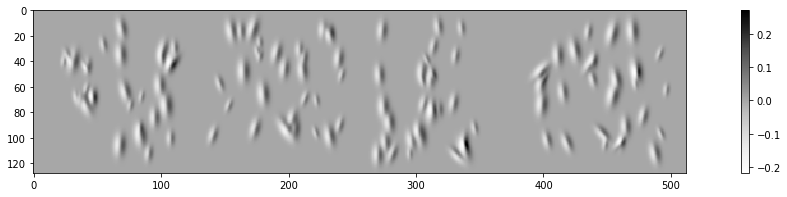

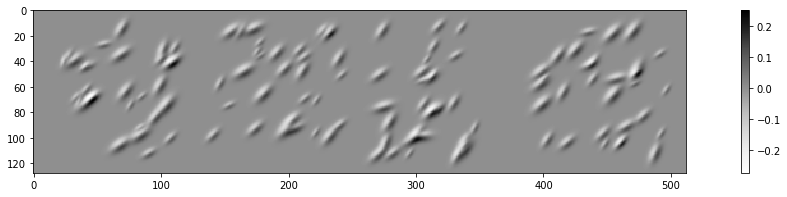

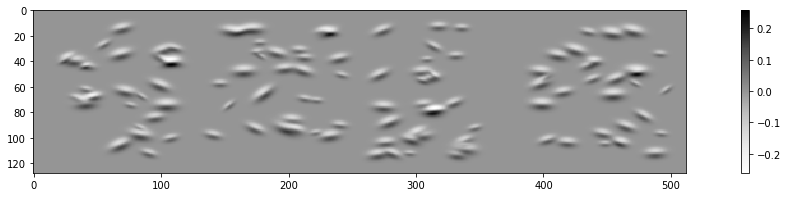

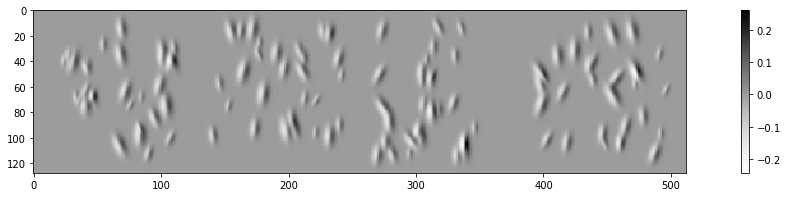

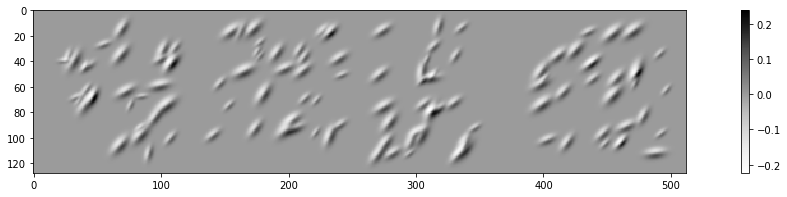

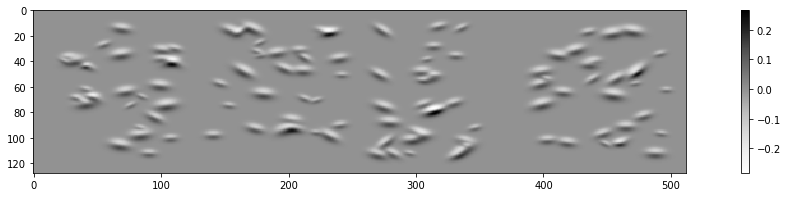

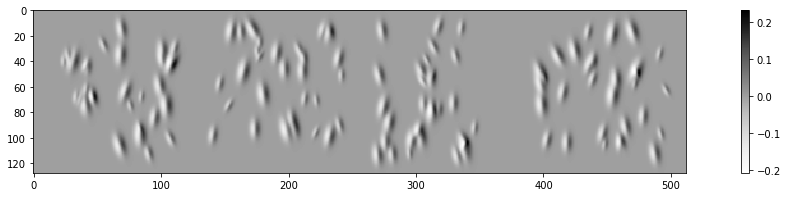

In [8]:
i = 0
for G in gabor_dl:    
    plt.figure(figsize=(20, 3))
    plt.imshow(np.concatenate(G.numpy()[0, :, 0, 0]).T, cmap=plt.cm.Greys);
    plt.colorbar()
    i += 1
    if i == 12:
        break